# Project 2 - Polynomial Models for Boston House Prices

## Group members

* Michael Peralta (mikeperalta@csu.fullerton.edu)
   
* Brandon Xue (brandonx@csu.fullerton.edu)

### CPSC 483-02, Section ID: 33018

# Experiment 1
Load and examine the Boston dataset’s features, target values, and description.

In [1]:

# Experiment 1

import sklearn.datasets as sklearn_datasets
import pandas as pd


# Import the Boston house prices dataset
# (load)
boston_house_data = sklearn_datasets.load_boston()


# Print out various properties of the Boston house prices dataset
# (examine)
print("--- Loaded Boston dataset; Ready for examination")
print("*" * 30)
print("> *** BEGIN DESCRIPTION ***")
print(boston_house_data.DESCR) # description
print("> *** END DESCRIPTION ***")
print("*" * 30)
print()
print("> Features shape:", boston_house_data.data.shape)
print("> Feature names: ", boston_house_data.feature_names) # feature names
print("> Number of Features:", len(boston_house_data.data[0,:])) # features
print("> Number of Target values:", len(boston_house_data.target)) # targets




--- Loaded Boston dataset; Ready for examination
******************************
> *** BEGIN DESCRIPTION ***
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of access

# Experiment 2
Use *sklearn.model_selection.train_test_split()* to split the features and values into separate training and test sets. Use 80% of the original data as a training set, and 20% for testing.


In [2]:
# Experiment 2
# Partition into training and testing sets


from sklearn import model_selection


# TODO: What is this?
# data_with_targets = zip(boston_house_data.data, boston_house_data.target)
# print("Data_with_targets:", data_with_targets)


# Load the boston data into a pandas data frame
boston_house_data_frame = pd.DataFrame(data=boston_house_data.data, columns=boston_house_data.feature_names)

# Add targets to same data frame so they stay paired with other data
boston_house_data_frame.insert(len(boston_house_data_frame.columns), 'TARGET', boston_house_data.target)

# Split the data into a training set (80%), and a test set (20%)
# train_test_split returns a list of the train-test split of inputs
boston_training_set, boston_testing_set = model_selection.train_test_split(
    boston_house_data_frame,  # Original data to split
    train_size=0.8,  # Retain 80% of the data for training (remaining becomes testing)
    random_state=113  # Randomize the data before splitting, but use a stable seed for repeatable results
)
print("Training set shape:", boston_training_set.shape)
print("Training set shape:", boston_training_set.shape)
print("Testing set shape:", boston_testing_set.shape)
print("Testing set shape:", boston_testing_set.shape)
print()



Training set shape: (404, 14)
Training set shape: (404, 14)
Testing set shape: (102, 14)
Testing set shape: (102, 14)



# Experiment 3
Create a *scatterplot* of the training set showing the relationship between the feature LSTAT and the target value MEDV.

***Question***: Does the relationship appear to be linear?

Text(0.5, 0.98, 'Training Data')

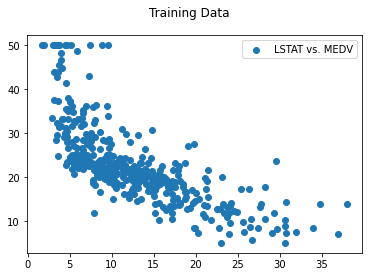

In [3]:
# Experiment 3. Scatter plot of training data

import matplotlib.pyplot as plt

# Ask pyplot for a figure and axis, for a new plot
fig, ax = plt.subplots()

# Show the relationship between feature LSTAT and TARGET values, using a scatter plot
ax.scatter(boston_training_set.LSTAT, boston_training_set.TARGET, label="LSTAT vs. MEDV")
ax.legend()
fig.suptitle("Training Data")

# TODO: What is this?
#retval = ax.set(xlabel="Training LSTAT (%)", ylabel="Training MEDV (1000 USD)", title="Training MEDV vs. Training LSTAT")

## Does the relationship appear to be linear?

The above relationship between the feature LSTAT and the target value MEDV does not quite appear to be linear. If we only examined LSTAT ranges from 10 to 25, it might, but the overall data appears to show a non-linear relationship.

# Experiment 4
With LSTAT as ***X*** and MEDV as ***t***, use *np.linalg.inv()* to compute ***w*** for the training set.

***Question***: What is the equation for MEDV as a linear function of LSTAT?

We will use the following formula to compute the weights:

$$
w = (X^TX)^{-1}X^Tt
$$

(found in the linear_regression_vectors_and_matrices.ipynb notebook)

The equation for MEDV as a linear function of LSTAT is written after the code below.

In [4]:

# Import numpy, yay
import numpy as np


# X will be LSTAT of the training set
# We can combine it with a preceding column of one's for the intercept
# (LSTAT will be the next column)

# Pull LSTAT from the training set, and stick it into a numpy array
x_lstat_training = np.array(boston_training_set["LSTAT"])  # Pull LSTAT from training
# print("x_lstat_training:", x_lstat_training)
print("x_lstat_training shape:", x_lstat_training.shape)
print()

# Now, X_lstat_linear_training will be the matrix we'll solve against (training data)
# Start with the x_lstat_training values in a column of a matrix
X_lstat_linear_training = x_lstat_training.reshape(x_lstat_training.shape[0], 1)
# Stick 1's for the intercept in the first column then the LSTAT column as the second column
X_lstat_linear_training = np.hstack((np.ones_like(X_lstat_linear_training), X_lstat_linear_training))
# print("X_lstat_linear_training: ", X)
print("X_lstat_linear_training shape:", X_lstat_linear_training.shape)
print()


# Build each part of the formula piece by piece
XTX = np.dot(X_lstat_linear_training.T, X_lstat_linear_training)
XTX_inv = np.linalg.inv(XTX)
XTt = np.dot(X_lstat_linear_training.T, boston_training_set["TARGET"])
lstat_linear_weights = np.dot(XTX_inv, XTt)
# print("XTX:", XTX)
print("XTX shape:", XTX.shape)
# print("XTX^-1:", XTX_inv)
print("XTX^-1 shape:", XTX_inv.shape)
print("XTt:", XTt)
print("XTt shape:", XTt.shape)
print("lstat_linear_weights:", lstat_linear_weights)
print("lstat_linear_weights shape:", lstat_linear_weights.shape)
print()



x_lstat_training shape: (404,)

X_lstat_linear_training shape: (404, 2)

XTX shape: (2, 2)
XTX^-1 shape: (2, 2)
XTt: [ 9152.4   96065.778]
XTt shape: (2,)
lstat_linear_weights: [34.38436369 -0.93878862]
lstat_linear_weights shape: (2,)



## Equation for MEDV as a linear function of LSTAT
The equation for MEDV as a linear function of LSTAT is:

$$
y = 34.38436369 + (-0.93878862 * \text{LSTAT})
$$

or rather:

$$
y = 34.38436369 -0.93878862(\text{LSTAT})
$$


# Experiment 5

Use **w** to add a line to your scatter plot from experiment *(3)*.

***Question***: How well does the model appear to fit the training set?


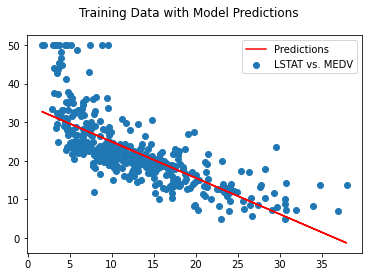

In [5]:

# Experiment 5


# Make some predictions for the training data
# i.e., show the model's linear ... line
predictions_lstat_linear_training = np.dot(X_lstat_linear_training, lstat_linear_weights)


# Ask pyplot for a figure and axis, for a new plot
fig, ax = plt.subplots()


# Show the relationship between feature LSTAT and TARGET values, using a scatter plot
# (training data)
ax.scatter(boston_training_set.LSTAT, boston_training_set.TARGET, label="LSTAT vs. MEDV")
ax.plot(x_lstat_training, predictions_lstat_linear_training, 'r-', label="Predictions")
fig.suptitle("Training Data with Model Predictions")
ax.legend()


# How well does the model appear to fit the training set?
The model fits ... not very well with the training set. It probably has a lot more error than we would like.

# Experiment 6
Use **w** to find the response for each value of the LSTAT attribute in the test set, then compute the test *MSE L* for the model.

In [6]:


# Pull LSTAT from the testing set, and stick it into a numpy array
x_lstat_testing = np.array(boston_testing_set["LSTAT"])  # Pull LSTAT from testing
print("x_lstat_testing shape:", x_lstat_testing.shape)
# print("x_lstat_testing:", x_lstat_testing)
print()

# Now, X_lstat_linear_testing will be the matrix we'll solve against (training data)
# Start with the x_lstat values in a column of a matrix
X_lstat_linear_testing = x_lstat_testing.reshape(x_lstat_testing.shape[0], 1)
# Stick 1's for the intercept in the first column then the LSTAT column as the second column
X_lstat_linear_testing = np.hstack((np.ones_like(X_lstat_linear_testing), X_lstat_linear_testing))
# print("X_lstat_linear_testing: ", X_lstat_linear_testing)
print("X_lstat_linear_testing shape:", X_lstat_linear_testing.shape)
print()


#
predictions_lstat_linear_testing = np.dot(X_lstat_linear_testing, lstat_linear_weights)
print("predictions_lstat_linear_testing shape:", predictions_lstat_linear_testing.shape)

# TODO: Is there a more numpy-y way to do this?
print("boston_testing_set.TARGET:", boston_testing_set.TARGET)
print("boston_testing_set.TARGET shape:", boston_testing_set.TARGET.shape)
graph_x = []
graph_t = []
graph_y = []  # Build the graph as we traverse the predictions, to be sure we're pulling correct values
error_temp_sum = 0
for n in range(len(predictions_lstat_linear_testing)):
    
    lstat = boston_testing_set.LSTAT.iloc[n]
    graph_x.append(lstat)
    
    t = boston_testing_set.TARGET.iloc[n]
    graph_t.append(t)
    
    y = predictions_lstat_linear_testing[n]
    graph_y.append(y)
    
    error_squared = (t - y)**2
    error_temp_sum += error_squared
    
    # print("Prediction:", y)
    # print("Actual:", t)
    # print("Error Squared:", error_squared)
    # print()

mean_squared_error = error_temp_sum / len(predictions_lstat_linear_testing)
print("MSE for the linear model:", mean_squared_error)
print()



x_lstat_testing shape: (102,)

X_lstat_linear_testing shape: (102, 2)

predictions_lstat_linear_testing shape: (102,)
boston_testing_set.TARGET: 22     15.2
202    42.3
368    50.0
335    21.1
461    17.7
       ... 
86     22.5
193    31.1
5      28.7
282    46.0
232    41.7
Name: TARGET, Length: 102, dtype: float64
boston_testing_set.TARGET shape: (102,)
MSE for the linear model: 39.95751318608693



# MSE For Linear Model

The MSE for the linear model appears to be: 39.95751318608693